# План симуляций
0. Превышение критической энергии, условие  возникновения лавины.
1. Симуляции паратметров электронной лавины без учета гамма-квантов
2. Расчет длинны нарастания лавины для разных высот и полей (делая поправку для поля на высоту)
3. Расчет средней энергии электронов, спектра электронов, зависимости от начальной энергии




In [1]:
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
import tables
import matplotlib as mpl

In [1]:
path = "/home/zelenyy/data/thunderstorm/test/result.hdf5"
path = "/mnt/storage2/phd/data/thunderstorm/critical_energy/result.hdf5"

In [2]:
with tables.open_file(path) as h5file:
    # print(h5file)
    for group in h5file.root:
        print(group._v_name)
        # table = h5file.get_node(group, "stacking_simple")
        # print(repr(table.attrs))
        # data = table.read()
        break

NameError: name 'tables' is not defined

In [ ]:
bins = np.arange(0.001, 2, 0.001)


In [3]:
@dataclass
class CEData:
    number : int
    energy : float
    hist : np.ndarray

def select_data(table, field, height):
    m_field = table.attrs["values_gdml_field"][0]
    m_height = table.attrs["values_gdml_height"][0]
    return np.isclose([m_field, m_height], [field, height]).all()

def get_data(path, field = 0.0, height = 0.0):
    result = []
    bins = np.arange(0.001, 2, 0.001)
    with tables.open_file(path) as h5file:
        for group in h5file.root:
            table = h5file.get_node(group, "stacking_simple")
            if select_data(table, field, height):
                data = table.read()
                energy =  table.attrs["values_macros_energy"]
                number =  table.attrs["values_macros_number"]
                hist, _ = np.histogram(data["energy"], bins=bins)
                result.append(CEData(number, energy, hist))
    return result, bins

In [5]:
ce_list, bins = get_data(path, field=9e-4)

In [6]:
ce_list = sorted(ce_list, key=lambda x: x.energy)

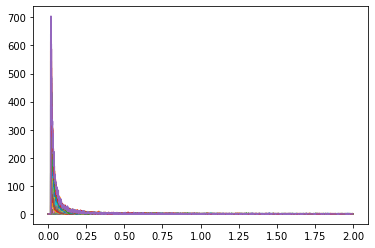

In [7]:
for item in ce_list:
    plt.step(bins[:-1], item.hist)

In [9]:
for item in ce_list:
    print(item.hist.sum()/item.number, ce_list.index(item))

0.0 0
0.0 1
0.0 2
0.0 3
0.0 4
0.0 5
0.0 6
0.0 7
0.0 8
0.0 9
0.0 10
0.0 11
0.0 12
0.0 13
0.0 14
0.0 15
0.0 16
0.0 17
0.0 18
0.0 19
0.0 20
0.02 21
0.0 22
0.01 23
0.06 24
0.0 25
0.02 26
0.02 27
8.08 28
0.06 29
0.07 30
7.14 31
0.07 32
7.19 33
34.08 34
6.33 35
14.28 36
0.12 37
21.76 38
21.16 39
27.0 40
20.58 41
35.33 42
28.43 43
53.41 44
33.91 45
93.42 46
57.15 47
74.94 48
91.7 49
93.36 50
133.88 51
119.67 52
141.23 53
149.68 54


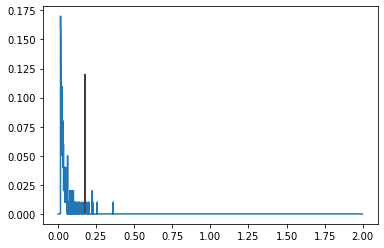

In [65]:
item = ce_list[-1]
n = 100
plt.step(bins[:-1], item.hist/item.number)
plt.vlines(item.energy, 0, 0.12)

In [4]:
def get_data_event(path, field = 0.0, height = 0.0):
    result = []
    with tables.open_file(path) as h5file:
        for group in h5file.root:
            table = h5file.get_node(group, "stacking_simple")
            if select_data(table, field, height):
                data = table.read()
                energy =  table.attrs["values_macros_energy"]
                number =  table.attrs["values_macros_number"]
                _, temp  = np.unique(data["event"], return_counts=True)
                result.append(CEData(number, energy, temp))
    return result

In [11]:
event_list = get_data_event(path, field=9e-4)

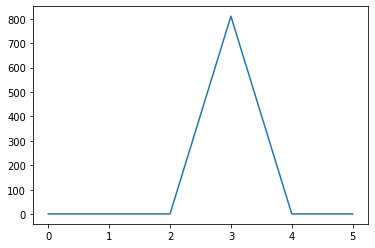

In [14]:
item = event_list[28]
plt.plot(item.hist)

In [9]:
def get_data_z(path, field = 0.0, height = 0.0):
    result = []
    bins = np.arange(-500.0, 501, 1)
    with tables.open_file(path) as h5file:
        for group in h5file.root:
            table = h5file.get_node(group, "stacking_simple")
            if select_data(table, field, height):
                data = table.read()
                energy =  table.attrs["values_macros_energy"]
                number =  table.attrs["values_macros_number"]
                temp, _ = np.histogram(data["z"], bins=bins)
                temp = np.cumsum(temp)
                result.append(CEData(number, energy, temp))
    return result

In [10]:
z_list = get_data_z(path, field=9e-4)


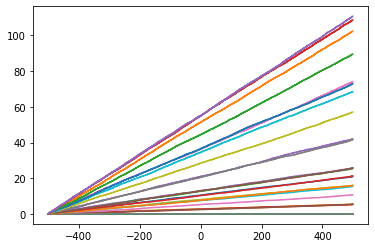

In [12]:
bins = np.arange(-500.0, 501, 1)
for item in z_list:
    plt.step(bins[:-1], item.hist/item.number)

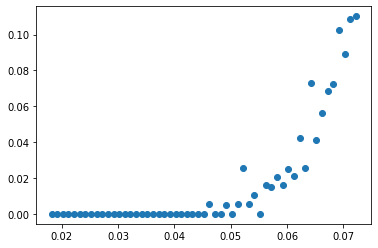

In [14]:
from scipy.linalg import lstsq

bins = np.arange(-500.0, 501, 1)
energy = []
k = []
for item in z_list:
    x = bins[:-1]
    y = item.hist/item.number
    M = x[:, np.newaxis]**[0, 1]
    p, res, rnk, s = lstsq(M, y)
    energy.append(item.energy)
    k.append(p[1])
plt.plot(energy, k, "o")

In [2]:
path = "/mnt/storage2/phd/data/thunderstorm/critical_energy/critical_energy.npy"


In [3]:
data = np.load(path)

In [4]:
indx = np.logical_and(data["height"] == 0.0, data["field"] == 11e-4)

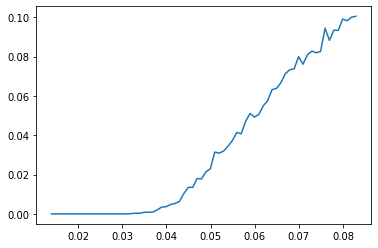

In [5]:
plt.plot(data["energy"][indx], data["k"][indx])

In [13]:
x = data["energy"][indx]
y =  data["k"][indx]

24

In [29]:
x[24]

0.03794049151049629

In [32]:
result = []
fh = np.unique(data[["height", "field"]], axis=0)
for item in fh:
    height, field = item
    indx = np.logical_and(data["height"] == height, data["field"] == field)
    x = data["energy"][indx]
    y =  data["k"][indx]
    indx = (y > 0.001).argmax()
    result.append((height, field, x[indx]))

In [33]:
from mpl_toolkits.mplot3d import Axes3D

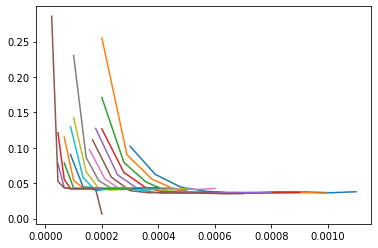

In [36]:
data_scatter = np.array(result)
heights = np.unique(fh["height"])
for height in heights:
    indx = data_scatter[:, 0] == height
    x = data_scatter[indx, 1]
    y = data_scatter[indx, 2]
    plt.plot(x,y)

In [7]:
from scipy.optimize import curve_fit

In [25]:
def sigmoid(x, alpha, beta):
    return np.exp(x/alpha) + beta

popt, _ = curve_fit(sigmoid, x,y, [1.0, 0.0])

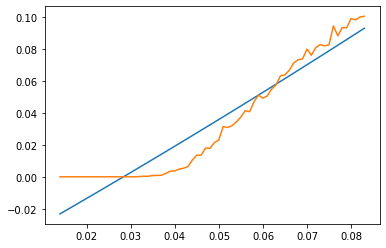

In [26]:
plt.plot(x, sigmoid(x, *popt))
plt.plot(x,y)

In [27]:
popt

array([ 0.64071317, -1.04523218])